# Using RCNN: Examples of CNN networks¶

1. using the compiled libraries (GSL)
2. using the native R libraries

CNNs and MLPs can be trained and used by describing the layers composing the neural network. For CNNs we're using convolutional related layers plus flat layers, while with MLPs we're only using the later ones. Also inputs for CNNs must be 4 dimensional, while for MLPs must be 2 dimensional

#### Load Libraries

In [1]:
library(rcnn);

library(ggplot2);
library(reshape2);

## CNNs: the MNIST example

### Load Dataset

* Previously it could be loaded through the RDS package.
* Now, it is included in the package datasets as "mnist"

In [2]:
data(mnist)

Datasets must be shaped as [batch_size x channels x height x width]

In [3]:
img_size <- c(28,28);

training_x <- array(mnist$train$x, c(nrow(mnist$train$x), 1, img_size)) / 255;
training_y <- binarization(mnist$train$y);

testing_x <- array(mnist$test$x, c(nrow(mnist$test$x), 1, img_size)) / 255;
testing_y <- binarization(mnist$test$y);

A visualization of a sample of the training Dataset

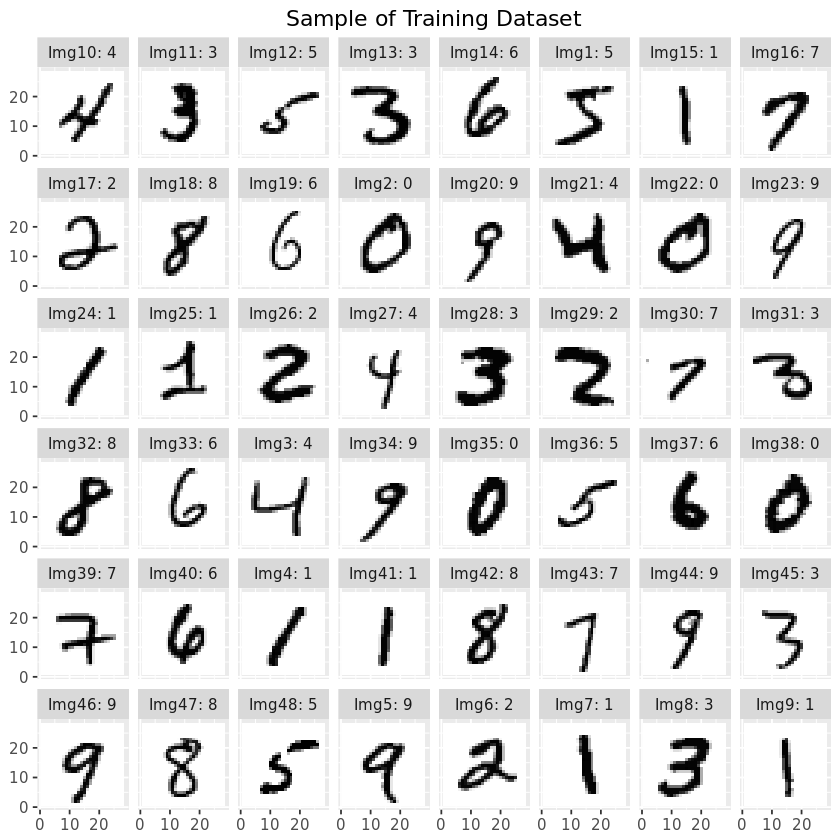

In [4]:
printset <- training_x[1:48,1,,,drop=TRUE];
longData <- melt(printset)
longData$Var2 <- (longData$Var2 - 1) %% 28 + 1;
longData$Var3 <- 29 - longData$Var3;
longData$Var1 <- paste("Img", longData$Var1, ": ", mnist$train$y[1:48], sep="")

ggplot(data = longData) +
geom_tile(aes(Var2, Var3, fill = value)) +
facet_wrap(~Var1, nrow = 6) +
scale_fill_continuous(low = 'white', high = 'black') +
coord_equal() +
labs(x = NULL, y = NULL, title = "Sample of Training Dataset") +
theme(legend.position = "none")

### Prepare the Convolutional MLP Network (CNN)

The layer descriptor must be a list of vectors with the hyperparameters. Check the help for train.cnn to see the list of layers and the properties of each kind

In [5]:
layers <- list(
    c('type' = "CONV", 'n_channels' = 1, 'n_filters' = 4, 'filter_size' = 5, 'scale' = 0.1, 'border_mode' = 'same'),
    c('type' = "POOL", 'n_channels' = 4, 'scale' = 0.1, 'win_size' = 3, 'stride' = 2),
    c('type' = "RELU", 'n_channels' = 4),
    c('type' = "FLAT", 'n_channels' = 4),
    c('type' = "LINE", 'n_visible' = 784, 'n_hidden' = 10, 'scale' = 0.1),
    c('type' = "SOFT", 'n_inputs' = 10)
);

### Train the CNN

The CNN receives as inputs:

* training_x: the datasets to be trained with
* training_y: the labels for the training dataset
* layers: the descriptor of the network layers

Also receives the following hyperparameters:

* batch_size: the size of each training mini-batch
* training_epochs: the number of training epochs
* learning_rate: the learning rate for Gradient Descent
* rand_seed: the random seed for selecting samples and stochastic layers

In [6]:
mnist_cnn <- train.cnn(training_x,
                       training_y,
                       layers,
                       batch_size = 10,
                       training_epochs = 20,
                       learning_rate = 1e-3,
                       rand_seed = 1234
);

### Predict using the CNN

In [7]:
prediction <- predict(mnist_cnn, testing_x);
str(prediction)

List of 2
 $ score: num [1:10000, 1:10] 0.0598 0.111 0.0381 0.5595 0.1038 ...
 $ class: int [1:10000] 8 9 2 1 5 2 10 10 1 10 ...


Plot some Results

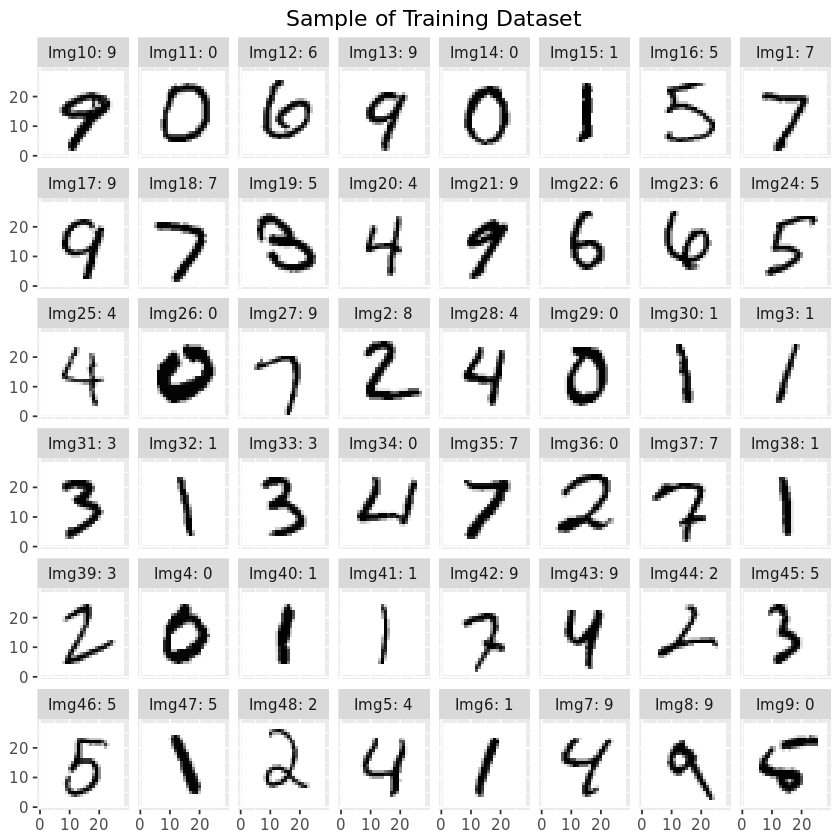

In [8]:
printset <- testing_x[1:48,1,,,drop=TRUE];
longData <- melt(printset)
longData$Var2 <- (longData$Var2 - 1) %% 28 + 1;
longData$Var3 <- 29 - longData$Var3;
longData$Var1 <- paste("Img", longData$Var1, ": ", prediction$class[1:48] - 1, sep="")

ggplot(data = longData) +
geom_tile(aes(Var2, Var3, fill = value)) +
facet_wrap(~Var1, nrow = 6) +
scale_fill_continuous(low = 'white', high = 'black') +
coord_equal() +
labs(x = NULL, y = NULL, title = "Sample of Training Dataset") +
theme(legend.position = "none")

In [9]:
table(prediction$class - 1, mnist$test$y);

   
       0    1    2    3    4    5    6    7    8    9
  0  931    0   60    0   31   34  100    6   44   34
  1    1 1081   45   23   10   20   30   73   63   23
  2    3   23  720   22   12    2   33   21   12    3
  3   11    3   22  649    0   52    2   13   14    5
  4    0    0    5    0  616   27    8    7   15   35
  5    1   12    7   42    0  313   18    7   25    6
  6    3    4   42    2   55   15  723    3   23   13
  7    4    0   63   23    0    7    3  426   18    4
  8    5   12   58   38    5  192   35    2  272    4
  9   21    0   10  211  253  230    6  470  488  882

### Update / Re-train a CNN

You can pass a trained CNN as initial values for a new CNN. The structure (layers) will be copied from the old CNN. The function returns a new updated copy of the old CNN

In [10]:
mnist_cnn_update <- train.cnn(training_x,
                              training_y,
                              batch_size = 10,
                              training_epochs = 3,
                              learning_rate = 1e-3,
                              rand_seed = 1234,
                              init_cnn = mnist_cnn
);

## Using the R native functions

In [11]:
rm (list = ls());

### Load the R sources

In [12]:
setwd("..");
source("./cnn.R");
setwd("./notebooks");

### Load Dataset

In [13]:
mnist <- readRDS("../datasets/mnist.rds");

In [14]:
img_size <- c(28,28);

training_x <- array(mnist$train$x, c(nrow(mnist$train$x), 1, img_size)) / 255;
training_y <- binarization(mnist$train$y);

testing_x <- array(mnist$test$x, c(nrow(mnist$test$x), 1, img_size)) / 255;
testing_y <- binarization(mnist$test$y);

Let's reduce the dataset size for this example

training_x <- training_x[1:1000,,,, drop=FALSE];
training_y <- training_y[1:1000,, drop=FALSE];

testing_x <- testing_x[1:1000,,,, drop=FALSE];
testing_y <- testing_y[1:1000,, drop=FALSE];

### Prepare the Convolutional MLP Network (CNN)

The same layer descriptor works for the native R version

In [15]:
layers <- list(
    c('type' = "CONV", 'n_channels' = 1, 'n_filters' = 4, 'filter_size' = 5, 'scale' = 0.1, 'border_mode' = 'same'),
    c('type' = "POOL", 'n_channels' = 4, 'scale' = 0.1, 'win_size' = 3, 'stride' = 2),
    c('type' = "RELU", 'n_channels' = 4),
    c('type' = "FLAT", 'n_channels' = 4),
    c('type' = "LINE", 'n_visible' = 784, 'n_hidden' = 10, 'scale' = 0.1),
    c('type' = "SOFT", 'n_inputs' = 10)
);

### Train the CNN

The native R CNN is trained like the one in the package

In [16]:
cnn1 <- train_cnn(training_x = training_x,
                  training_y = training_y,
                  layers = layers,
                  batch_size = 10,
                  training_epochs = 20,
                  learning_rate = 1e-3,
                  rand_seed = 1234
);

[1] "Epoch 1 : Mean Loss 2.29847085680445 Accuracy : 0.122233333333338"
[1] "Epoch 2 : Mean Loss 2.28858041264648 Accuracy : 0.139400000000006"
[1] "Epoch 3 : Mean Loss 2.28234442851853 Accuracy : 0.112750000000006"
[1] "Epoch 4 : Mean Loss 2.27501391823635 Accuracy : 0.103816666666671"
[1] "Epoch 5 : Mean Loss 2.25577770449807 Accuracy : 0.145683333333339"
[1] "Epoch 6 : Mean Loss 2.18168585778389 Accuracy : 0.222866666666668"
[1] "Epoch 7 : Mean Loss 1.95453534053976 Accuracy : 0.401833333333334"
[1] "Epoch 8 : Mean Loss 1.5882228307954 Accuracy : 0.592999999999994"
[1] "Epoch 9 : Mean Loss 1.25618041273423 Accuracy : 0.703483333333333"
[1] "Epoch 10 : Mean Loss 1.024028115944 Accuracy : 0.75926666666667"
[1] "Epoch 11 : Mean Loss 0.874125644552483 Accuracy : 0.792166666666671"
[1] "Epoch 12 : Mean Loss 0.77546080269795 Accuracy : 0.811716666666671"
[1] "Epoch 13 : Mean Loss 0.707249658204844 Accuracy : 0.825666666666673"
[1] "Epoch 14 : Mean Loss 0.657703462979931 Accuracy : 0.83635

### Predict using the CNN

In the native version, predict_cnn is not seen as an S3 method

In [17]:
prediction <- predict_cnn(cnn1, testing_x);
str(prediction)

List of 2
 $ score: num [1:10000, 1:10] 0.00396 0.01146 0.00304 0.96718 0.00904 ...
 $ class: int [1:10000] 8 3 2 1 5 2 5 10 7 10 ...


### Update / Re-train the CNN

In [18]:
cnn1_update <- train_cnn(training_x = training_x,
                         training_y = training_y,
                         layers = layers,
                         batch_size = 10,
                         training_epochs = 3,
                         learning_rate = 1e-3,
                         rand_seed = 1234,
                         init_cnn = cnn1
);

[1] "Epoch 1 : Mean Loss 0.507261769303063 Accuracy : 0.867633333333337"
[1] "Epoch 2 : Mean Loss 0.497166400399894 Accuracy : 0.86966666666667"
[1] "Epoch 3 : Mean Loss 0.48830740736124 Accuracy : 0.871533333333337"


In [19]:
#save.image(file="rcnn.data")